### Grover's Algorithm - Demo

As we saw in the lecture, in Grover's algorithm we are given on oracle, O, which takes $ O|w\rangle = -|w\rangle$, where $w$ is the "winner". We can then perform the following to obtain a high probability of measuring $w$:

1. Prepare uniform superposition
2. 
    * Apply oracle function (O)
    * Apply diffusion operator (D)
    * (Repeat $O(\sqrt{N})$ times, where $N$ is the size of the search space)
3. Measure

Let's go through the code for the 3 qubit example given in lecture. Recall that we are saying the winner is "111"


Very briefly, let's see the runtime for a randomised classical algorithm

In [1]:
import random
import numpy as np

def oracle(y):
    return y == '111'

def classical_search(search_space):
    x = ''
    queries = 0
    while not oracle(x):

        x = random.choice(search_space)
        search_space.remove(x)
        queries += 1

    #print("found", x, "after", queries, "queries")
    return queries

qs = [classical_search(['000', '001', '010', '011', '100', '101', '110', '111']) for _ in range(100)]
print("Average number of queries: ", np.mean(qs))

Average number of queries:  4.76


Now let's see the quantum circuit. We're going to a boolean oracle and then the phase kickback trick to make it change the phase of the input.

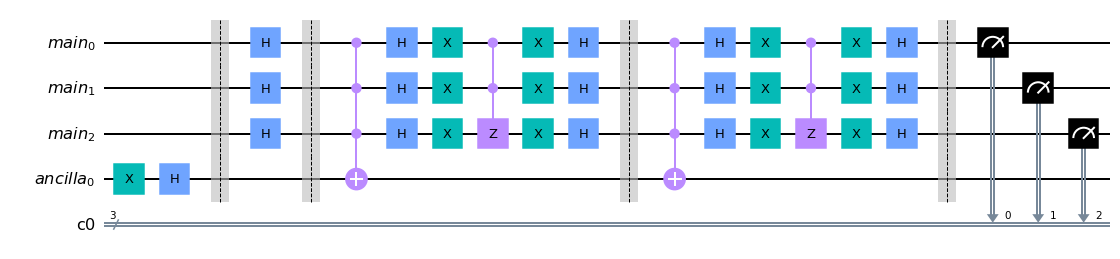

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZGate

n = 3

qc = QuantumCircuit(QuantumRegister(n, 'main'), QuantumRegister(1, 'ancilla'), ClassicalRegister(3))

##Step 0 - put ancilla qubit into |-> state
qc.x(3)
qc.h(3)
qc.barrier()

##Step 1 - prepare uniform superposition

qc.h(range(n))

qc.barrier()

##Step 2 - apply G = DO k times 


k = 2 #since N = 2^3, we want root(N) = root(8) = 2 * root(2) ≈ 2 iterations

for i in range(k):
    
    #apply oracle
    qc.mct([0,1,2], 3) #mct stands for multi-controlled toffoli 
    
    #apply diffusion (flip sign of |000>)
    ccz = ZGate().control(2)
    qc.h(range(n))
    qc.x(range(n))
    qc.append(ccz, range(n))
    qc.x(range(n))
    qc.h(range(n))
    
    qc.barrier()
    

##Step 3 - Measure

qc.measure(range(n), range(n))
    
qc.draw(output='mpl')

So let's see the (simulated) results!

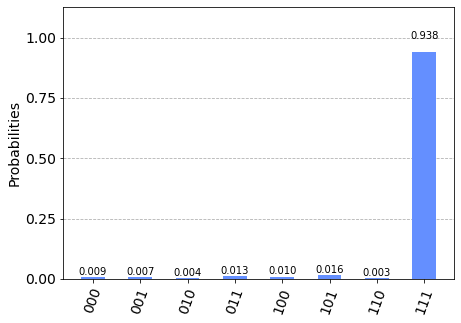

In [3]:
from qiskit import execute, BasicAer
from qiskit.visualization import plot_histogram

backend = BasicAer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=1000).result().get_counts()

plot_histogram(results)

Pretty good!

What about if we'd tried a different number of iterations?

Its all very well finding 111 after we explictly told it to, but can Grover's do anything useful? 

The answer is yes!

### 3 SAT

In this part, we are going to solve a satisfiability (SAT) problem using Grover's algorithm. 

A SAT problem is a list of OR statements connected by ANDs. When there are at most 3 letters ("literals") OR'ed together, the problem is called 3SAT (which is know to be NP-Complete). 

The problem we'll look at involves whether or not 4 people (Alice, Bob, Charles and Daisy) are going to attend a party. The issue is that these 4 have some complicated relationships. Let a mean that Alice is attending, and so on. Then we can express their relationships like so:
1. Charles and Daisy are hosting the party so at least one of them has to be there (c OR d)
2. Alice has a crush on Bob, so will definitely go if he does (b => a, a OR !b)
3. Charles would rather not third wheel, so will definitely go if Alice and Bob aren't both going (!a OR !b OR c)
4. Daisy won't go if Alice does (a => !d, !a or !d)

The key trick is the rule that you can rewrite $p => q$ to $q  \lor  !p$

3SAT problems are always rewritten in conjunctive normal form (OR statements being AND'ed together). In order to make it an oracle with qiskit, we have to write it in a special form call DIMACS CNF. To do that, we need to tell it how many variables we have and how many clauses we're using. We also need to number our variables so let a=1, b=2, c=3, d=4. Then we write equation on a different line ending with 0. This gives:

    p cnf 3 4
    3 4 0
    1 -2 0
    -1 -2 3 0
    -1 -4 0 

Ok so lets first see how to do this classically again. First well build the oracle function and then randomly sample it. We'll assume that it takes in the input as "abcd"

In [4]:
def classical_oracle(x):
    a, b, c, d = x
    
    a = int(a)
    b = int(b)
    c = int(c)
    d = int(d)
    
    #rule 1 - c OR d
    #rule 2 - !b OR a
    #rule 3 - !a or !b or c
    #rule 4 - !a or !d
    if  (c or d) and (not b or a) and (not a or not b or c) and (not a or not d):
        return True
    
    return False

def random_search(search_space):

    x = '0000'
    queries = 0
    while not classical_oracle(x):
        x = random.choice(search_space)
        search_space.remove(x)
        
        queries += 1
    
    #print("Found solution with", x)
    return x, queries
        
s = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111','1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
random_search(s.copy())


('0011', 1)

In [5]:
#all solutions:
print("all solutions: ", set([random_search(s.copy())[0] for i in range(50)]))

all solutions:  {'0011', '1110', '0010', '1010', '0001'}


In [6]:
#average number of queries to get 1 solutions
qs = [random_search(s.copy())[1] for _ in range(100)]
print("Average number of queries: ", np.mean(qs))

Average number of queries:  2.8


In [7]:
from qiskit.aqua.components.oracles import LogicalExpressionOracle
input_3sat = """
p cnf 3 4
3 4 0
1 -2 0
-1 -2 3 0
-1 -4 0 
"""
oracle = LogicalExpressionOracle(input_3sat)


This constructs a circuit with a 4 qubit variable register, a 4 qubit "workspace" register, some ancillas for mct's and a 1 qubit output register which carries the solution.

We can see what is happening under the hood if we want, but remember that the point is that we really don't care...

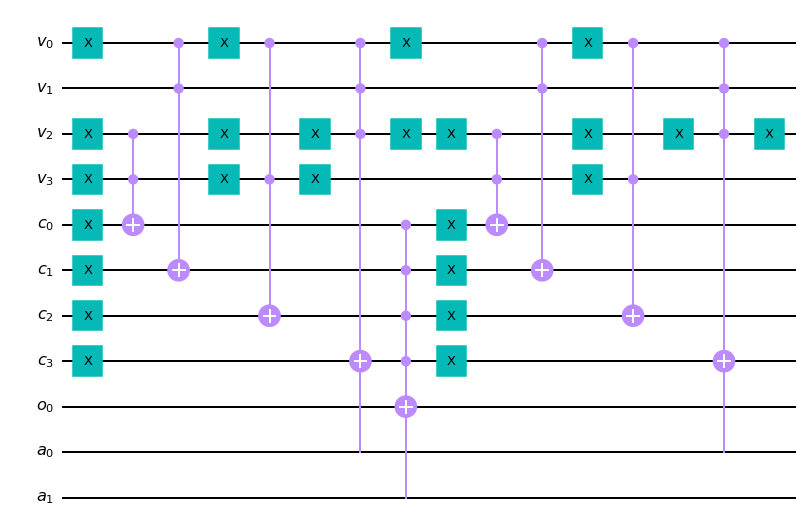

In [8]:
oracle.construct_circuit().draw(output='mpl')

We can then just use the qiskit Grover's module to splice build the oracle into a Grover's and all we have to do is choose the number of iterations.

Since there are 4 variables, we know there are 2^4 = 16 possible assigments. However, we don't know the number of solutions (yet), so let's just try 1 iteration and see what happens.

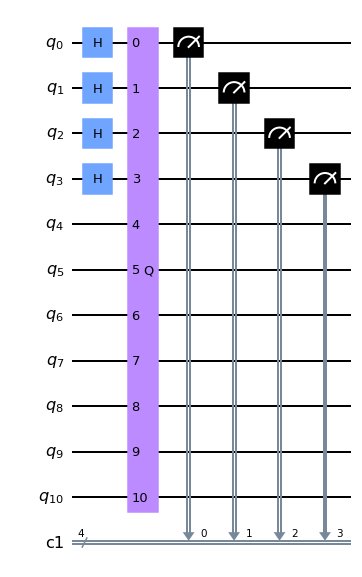

In [9]:
from qiskit.aqua.algorithms import Grover

grover = Grover(oracle, iterations=1)


qc = grover.construct_circuit()


qc.add_register(ClassicalRegister(4))
qc.measure(range(4), range(4))

qc.draw(output='mpl')


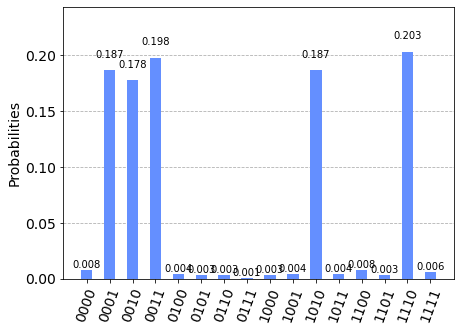

In [10]:
backend = BasicAer.get_backend('qasm_simulator')
results = execute(qc.reverse_bits(), backend, shots=1000).result().get_counts()

plot_histogram(results)

This gives us 5 answers: 
1. 0001 - Daisy goes 
2. 0010 - Charles goes 
3. 0011 - Charles and Daisy both go
4. 1010 - Alice and Charles go
5. 1110 - Alice, Bob and Charles go

Let's check these satisfy the rules (or just use our classical oracle)

In [11]:
solutions = ['0001', '0010', '0011', '1010', '1110']
for sol in solutions:
    print(sol, classical_oracle(sol))

0001 True
0010 True
0011 True
1010 True
1110 True
